In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')  

from nltk.sentiment.vader import SentimentIntensityAnalyzer  
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Embedding, LSTM, Dense, Concatenate
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import string
import re
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kulreen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_csv('D:/Sentiment Dataset/archive/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

In [4]:
df.columns = ['category', 'id', 'date', 'query', 'user', 'tweet']

In [5]:
df.head()

,category,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#0-Negative Sentiment
#4-Positive Sentiment
#We convert 4 to 1

df['category'] = df['category'].replace(4, 1)

<Axes: xlabel='category'>

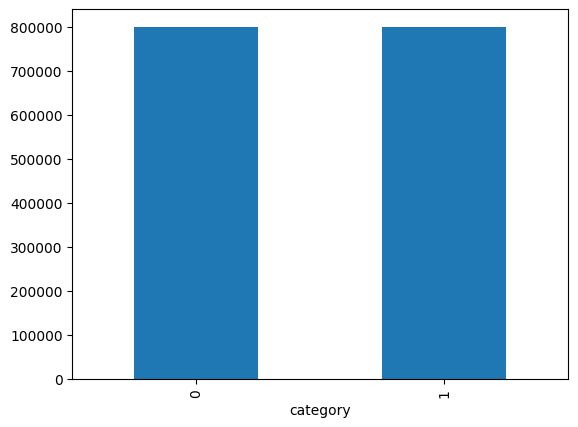

In [7]:
# a bar chart showing the count of comments in each category
df['category'].value_counts().plot(kind='bar')

In [8]:
df = df[['category', 'tweet']]

In [9]:
df['length'] = df['tweet'].str.len()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   category  1600000 non-null  int64 
 1   tweet     1600000 non-null  object
 2   length    1600000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 36.6+ MB


In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
category,1600000.0,0.500000,0.500000,0.0,0.0,0.5,1.0,1.0
length,1600000.0,74.090111,36.441139,6.0,44.0,69.0,104.0,374.0


In [12]:
#for null values
df.isnull().sum()

category    0
tweet       0
length      0
dtype: int64

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [14]:
#replacing url with string
def replace_url(text):
    return re.sub(r'https?:\/\/\S+|www\.\S+', 'URL', text)

#removing html
def remove_html(text):
    return re.sub('<.*?>', '', text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing number with string number
def replace_num(text):
    return re.sub(r'\d+', 'NUMBER', text)

def replace_heart(text):
  return re.sub('<3', 'HEART', text)

def remove_stopwords(text):
  text= ' '.join([word for word in text.split() if word not in stopwords.words('english')])
  return text

def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

#reducing words to their root form
def lemmatization(text):
  lm = WordNetLemmatizer()
  text= ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
  return text

In [15]:
#For LSTM
def clean_text(text):
  text = str(text).lower()
  text = contractions.fix(text)
  text =replace_url(text)
  text = remove_punctuations(text)
  text = remove_alphanumeric(text)
  text = replace_heart(text)
  text = remove_stopwords(text)
  text = remove_html(text)
  text = replace_mentions(text)
  text = lemmatization(text)
  text = replace_num(text)
  return text

In [16]:
#For VADER
def minimal_clean_text(text):
    text = str(text).lower()
    text = contractions.fix(text)
    text = replace_url(text)
    text = replace_mentions(text)
    text = replace_heart(text)
    return text

In [17]:
df['cleaned_tweet'] = df['tweet'].apply(clean_text)       
df['vader_text'] = df['tweet'].apply(minimal_clean_text)  

In [18]:
df['cleaned_tweet']

0          switchfoot URL awww bummer shoulda get david c...
1          upset cannot update facebook texting might cry...
2          kenichan dive many time ball manage save rest ...
3                            whole body feel itchy like fire
4                      nationwideclass behave mad cannot see
                                 ...                        
1599995                           wake school best feel ever
1599996       thewdbcom cool hear old walt interview â« URL
1599997                       ready mojo makeover ask detail
1599998      happy birthday boo alll time tupac amaru shakur
1599999          happy charitytuesday thenspcc sparkscharity
Name: cleaned_tweet, Length: 1600000, dtype: object

In [19]:
sid = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    return sid.polarity_scores(text)['compound']

df['vader_score'] = df['vader_text'].apply(get_vader_sentiment)
df[['tweet', 'vader_score']].head()

,tweet,vader_score
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",-0.2023
1,is upset that he can't update his Facebook by ...,-0.7500
2,@Kenichan I dived many times for the ball. Man...,0.4939
3,my whole body feels itchy and like its on fire,-0.2500
4,"@nationwideclass no, it's not behaving at all....",-0.6597


In [20]:
MAX_VOCAB = 70000  
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_tweet'])

X_seq = tokenizer.texts_to_sequences(df['cleaned_tweet'])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post')

In [21]:
# Total unique words 
V = len(tokenizer.word_index)
print("Total unique words:", V)

# first 100 word-index pairs
first_100_words = dict(list(tokenizer.word_index.items())[:100])
print(first_100_words)

Total unique words: 686910
{'<OOV>': 1, 'go': 2, 'get': 3, 'good': 4, 'work': 5, 'day': 6, 'like': 7, 'love': 8, 'url': 9, 'want': 10, 'cannot': 11, 'today': 12, 'time': 13, 'know': 14, 'think': 15, 'thank': 16, 'see': 17, 'miss': 18, 'back': 19, 'make': 20, 'lol': 21, 'one': 22, 'feel': 23, 'really': 24, 'come': 25, 'watch': 26, 'need': 27, 'still': 28, 'would': 29, 'new': 30, 'night': 31, 'well': 32, 'amp': 33, 'home': 34, 'look': 35, 'oh': 36, 'much': 37, 'last': 38, 'say': 39, 'twitter': 40, 'tomorrow': 41, 'sleep': 42, 'wish': 43, 'morning': 44, 'hope': 45, 'great': 46, 'take': 47, 'wait': 48, 'though': 49, 'haha': 50, 'way': 51, 'sad': 52, 'could': 53, 'fun': 54, 'try': 55, 'right': 56, 'bad': 57, 'happy': 58, 'sorry': 59, 'leave': 60, 'tonight': 61, 'find': 62, 'people': 63, 'nice': 64, 'better': 65, 'even': 66, 'start': 67, 'bed': 68, 'yeah': 69, 'tweet': 70, 'week': 71, 'show': 72, 'school': 73, 'us': 74, 'hate': 75, 'play': 76, 'guy': 77, 'weekend': 78, 'days': 79, 'follow': 

In [22]:
X_lstm = X_pad
X_vader = df['vader_score'].values.reshape(-1, 1)
y = df['category'].values

In [23]:
X_lstm_tv, X_lstm_test, X_vader_tv, X_vader_test, y_tv, y_test = train_test_split(
    X_lstm, X_vader, y, test_size=0.15, random_state=42
)

X_lstm_train, X_lstm_val, X_vader_train, X_vader_val, y_train, y_val = train_test_split(
    X_lstm_tv, X_vader_tv, y_tv, test_size=0.176, random_state=42
)

In [24]:
from tensorflow.keras.layers import Attention, Permute, Multiply
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

embedding_dim = 100
embedding_index = {}
with open("D:/Sentiment Dataset/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

embedding_matrix = np.zeros((MAX_VOCAB, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

input_lstm = Input(shape=(MAX_LEN,))
embedding = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, weights=[embedding_matrix],
                      input_length=MAX_LEN, trainable=False)(input_lstm)
lstm_out = LSTM(64, return_sequences=True)(embedding)

attention = Dense(1, activation='tanh')(lstm_out)
attention = tf.keras.layers.Flatten()(attention)
attention_weights = tf.keras.layers.Activation('softmax')(attention)
attention_weights = tf.keras.layers.RepeatVector(64)(attention_weights)
attention_weights = tf.keras.layers.Permute([2, 1])(attention_weights)

attended_output = tf.keras.layers.Multiply()([lstm_out, attention_weights])
x = GlobalMaxPooling1D()(attended_output)

x = Dropout(0.3)(x)  

input_vader = Input(shape=(1,))
y = Dense(16, activation='relu')(input_vader)
y = Dense(8, activation='relu')(y)

combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[input_lstm, input_vader], outputs=z)

c:\Users\Kulreen\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

optimizer = tf.keras.optimizers.Adam(clipnorm=1.0)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(
    [X_lstm_train, X_vader_train], y_train,
    validation_data=([X_lstm_val, X_vader_val], y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]  
)

Epoch 1/20
35020/35020 ━━━━━━━━━━━━━━━━━━━━ 831s 24ms/step - accuracy: 0.7479 - loss: 0.5093 - val_accuracy: 0.7752 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 2/20
35020/35020 ━━━━━━━━━━━━━━━━━━━━ 834s 24ms/step - accuracy: 0.7783 - loss: 0.4627 - val_accuracy: 0.7831 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 3/20
35020/35020 ━━━━━━━━━━━━━━━━━━━━ 953s 26ms/step - accuracy: 0.7857 - loss: 0.4518 - val_accuracy: 0.7848 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 4/20
35020/35020 ━━━━━━━━━━━━━━━━━━━━ 644s 18ms/step - accuracy: 0.7895 - loss: 0.4449 - val_accuracy: 0.7858 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 5/20
35020/35020 ━━━━━━━━━━━━━━━━━━━━ 500s 14ms/step - accuracy: 0.7928 - loss: 0.4392 - val_accuracy: 0.7860 - val_loss: 0.4516 - learning_rate: 0.0010
Epoch 6/20
35020/35020 ━━━━━━━━━━━━━━━━━━━━ 691s 20ms/step - accuracy: 0.7951 - loss: 0.4367 - val_accuracy: 0.7841 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 7/20
35017/35020 ━━━━━━━━━━━━━━━━━━━━ 0s

In [27]:
loss, accuracy = model.evaluate([X_lstm_test, X_vader_test], y_test)
print(f"Test Accuracy: {accuracy:.4f}")

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.7869 - loss: 0.4490
Test Accuracy: 0.7867


In [28]:

y_pred_prob = model.predict([X_lstm_test, X_vader_test])
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))



7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step
              precision    recall  f1-score   support

           0       0.79      0.78      0.79    119825
           1       0.79      0.79      0.79    120175

    accuracy                           0.79    240000
   macro avg       0.79      0.79      0.79    240000
weighted avg       0.79      0.79      0.79    240000



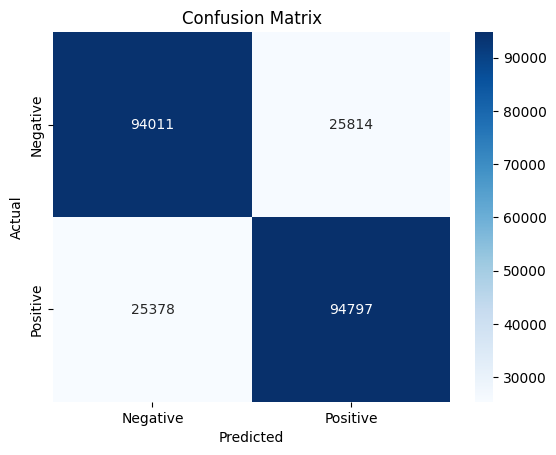

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [30]:
model.save('VADER_lstm_sentiment_model1.h5')

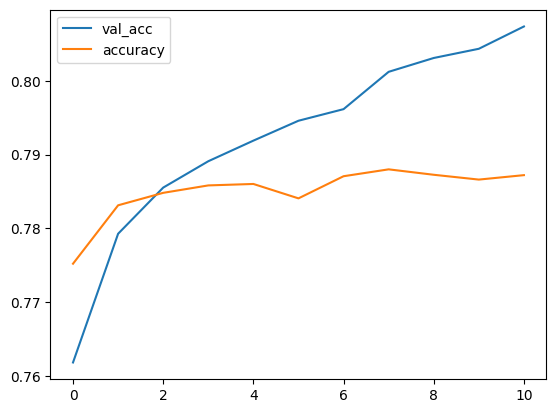

In [31]:
plt.plot(history.history['accuracy'], label='val_acc')
plt.plot(history.history['val_accuracy'], label='accuracy')
plt.legend()

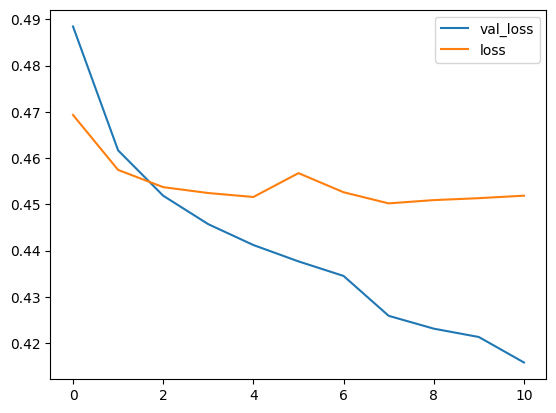

In [32]:
plt.plot(history.history['loss'], label='val_loss')
plt.plot(history.history['val_loss'], label='loss')
plt.legend()

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step
ROC AUC Score: 0.8708


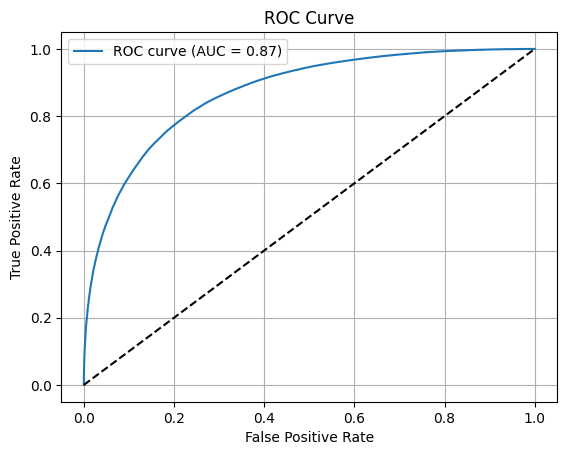

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities
y_prob = model.predict([X_lstm_test, X_vader_test])

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_score:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()
